In [ ]:
import os
from tqdm import tqdm
import numpy as np
import tifffile

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import spectral.io.envi as envi
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'font.size': 14})

In [ ]:
data_root = '../data/complex_facility/Images'
n_files = 231
all_imgs = []
all_pixels = []
for img_i in tqdm(range(n_files)):
    img = envi.open(os.path.join(data_root, f"MakoSpectrometer-t{img_i:04d}.img.hdr"))
    img = 1e6 * np.asarray(img.asarray())
    all_imgs.append(img)
    all_pixels.append(img.reshape((-1, 128)))

pixels = np.asarray(all_pixels).reshape((-1, 128))
stdizer = StandardScaler().fit(pixels)

100%|██████████| 231/231 [00:21<00:00, 10.56it/s]


In [3]:
def make_img_plottable(tmp_img, pca = None, max = 0.0019809045970402978, min = 0.00017077310969582421, channels=[59, 7, 15], scale=1):
    # tmp_img =  (tmp_img - 0.00017077310969582421) / (0.0019809045970402978 - 0.00017077310969582421)
    tmp_img = tmp_img.copy()
    if pca:
        og_shape = tmp_img.shape
        tmp_img = tmp_img.reshape((-1, 128))
        tmp_img = pca.transform(tmp_img)
        tmp_img = tmp_img.reshape(((128, 128, 3)))
        tmp_img = (tmp_img - min) / (max - min)
    else:
        tmp_img *= scale
        if max is None or min is None:
            tmp_img = ((tmp_img - tmp_img.min()) / (tmp_img.max() - tmp_img.min()))[:, :, channels]
        else:
            tmp_img = ((tmp_img - min) / (max - min))[:, :, channels]
    return tmp_img

In [4]:
x_new = np.linspace(7.8, 7.8 + 0.044 * 127, 128)
print(x_new[[59, 7, 15]])
print(x_new[0], x_new[-1])

[10.396  8.108  8.46 ]
7.8 13.388


In [ ]:
import os
import json
import numpy as np

# === Settings ===
base_folder = "../outputs/complex_facility"
experiments = ["hsi_mipnerf_L2", "hsi_mipnerf_MD_GR"]
sizes = [20, 30, 40, 50, 75, 100]
seeds = range(5)
target_image_ids = ["6", "22", "10", "72"]  # string keys match JSON

# === Initialize tracking structure ===
best_by_model = {
    exp: {
        size: {
            img_id: {
                "psnr": {"seed": None, "value": -np.inf},
                "tpr":  {"seed": None, "value": -np.inf},
                "auc":  {"seed": None, "value": -np.inf}
            }
            for img_id in target_image_ids
        }
        for size in sizes
    }
    for exp in experiments
}

# === Process files ===
for experiment in experiments:
    for size in sizes:
        for seed in seeds:
            filepath = os.path.join(
                base_folder,
                experiment,
                f"{size}_{seed}",
                "hsi-eval",
                "latest",
                "per_image_eval_metrics.json"
            )

            if not os.path.exists(filepath):
                print(f"❌ Missing: {filepath}")
                continue

            try:
                with open(filepath, "r") as f:
                    metrics = json.load(f)
            except Exception as e:
                print(f"⚠️ Error reading {filepath}: {e}")
                continue

            for img_id in target_image_ids:
                if img_id not in metrics:
                    continue

                img_metrics = metrics[img_id]

                # PSNR
                psnr = img_metrics.get("psnr", float("-inf"))
                if psnr > best_by_model[experiment][size][img_id]["psnr"]["value"]:
                    best_by_model[experiment][size][img_id]["psnr"]["value"] = psnr
                    best_by_model[experiment][size][img_id]["psnr"]["seed"] = seed

                # TPR (recall)
                tpr = img_metrics.get("tpr")
                if tpr is not None and not np.isnan(tpr):
                    if tpr > best_by_model[experiment][size][img_id]["tpr"]["value"]:
                        best_by_model[experiment][size][img_id]["tpr"]["value"] = tpr
                        best_by_model[experiment][size][img_id]["tpr"]["seed"] = seed
                
                auc = img_metrics.get("auc")
                if auc > best_by_model[experiment][size][img_id]["auc"]["value"]:
                    best_by_model[experiment][size][img_id]["auc"]["value"] = auc
                    best_by_model[experiment][size][img_id]["auc"]["seed"] = seed




from scipy.stats import gmean
import numpy as np

print("=== Per-Image Summary Score (Normalized Geometric Mean of PSNR, TPR, AUC) ===\n")

for experiment in best_by_model:
    print(f"\n🔍 {experiment}")
    for size in sizes:
        print(f"  📏 Size: {size}")
        for img_id in target_image_ids:
            psnr_val = best_by_model[experiment][size][img_id]["psnr"]["value"]
            tpr_val  = best_by_model[experiment][size][img_id]["tpr"]["value"]
            auc_val  = best_by_model[experiment][size][img_id]["auc"]["value"]

            # Normalize PSNR to [0, 1] assuming max ~50 dB
            psnr_norm = np.clip(psnr_val / 50.0, 1e-6, 1.0)
            tpr = np.clip(tpr_val, 1e-6, 1.0)
            auc = np.clip(auc_val, 1e-6, 1.0)

            score = gmean([psnr_norm, tpr, auc])

            print(f"    🖼️ Image {img_id:<3}:  PSNR = {psnr_val:.2f}   TPR = {tpr:.3f}   AUC = {auc:.3f}   →  Score = {score:.4f}")


=== Per-Image Summary Score (Normalized Geometric Mean of PSNR, TPR, AUC) ===


🔍 hsi_mipnerf_L2
  📏 Size: 20
    🖼️ Image 6  :  PSNR = 34.12   TPR = 0.496   AUC = 0.788   →  Score = 0.6436
    🖼️ Image 22 :  PSNR = 34.51   TPR = 0.196   AUC = 0.619   →  Score = 0.4373
    🖼️ Image 10 :  PSNR = 32.21   TPR = 0.284   AUC = 0.986   →  Score = 0.5647
    🖼️ Image 72 :  PSNR = 37.58   TPR = 0.451   AUC = 0.838   →  Score = 0.6573
  📏 Size: 30
    🖼️ Image 6  :  PSNR = 41.26   TPR = 0.943   AUC = 0.987   →  Score = 0.9158
    🖼️ Image 22 :  PSNR = 37.15   TPR = 0.541   AUC = 0.912   →  Score = 0.7157
    🖼️ Image 10 :  PSNR = 37.14   TPR = 0.507   AUC = 0.863   →  Score = 0.6877
    🖼️ Image 72 :  PSNR = 41.61   TPR = 0.570   AUC = 0.937   →  Score = 0.7632
  📏 Size: 40
    🖼️ Image 6  :  PSNR = 42.94   TPR = 0.927   AUC = 0.991   →  Score = 0.9239
    🖼️ Image 22 :  PSNR = 40.30   TPR = 0.585   AUC = 0.946   →  Score = 0.7640
    🖼️ Image 10 :  PSNR = 42.40   TPR = 0.866   AUC = 0.987   → 

In [ ]:
from scipy.stats import gmean
import numpy as np
import os
import json

# === Settings ===
base_folder = "../outputs/complex_facility"
experiments = ["hsi_mipnerf_L2", "hsi_mipnerf_MD_GR"]
sizes = [20, 40, 50, 100]
seeds = range(5)
target_image_ids = ["6", "22", "10", "72"]  # string keys match JSON

print("=== Best Seed per Image by Geometric Mean (PSNR, SSIM, TPR, AUC, 1-FPR) ===\n")

for experiment in experiments:
    print(f"\n🔍 {experiment}")
    for size in sizes:
        print(f"  📏 Size: {size}")

        for img_id in target_image_ids:
            best_seed = None
            best_score = -np.inf
            best_components = (None, None, None, None, None)

            for seed in seeds:
                filepath = os.path.join(
                    base_folder,
                    experiment,
                    f"{size}_{seed}",
                    "hsi-eval",
                    "latest",
                    "per_image_eval_metrics.json"
                )

                if not os.path.exists(filepath):
                    continue

                try:
                    with open(filepath, "r") as f:
                        metrics = json.load(f)
                except Exception:
                    continue

                if img_id not in metrics:
                    continue

                img_metrics = metrics[img_id]

                psnr = img_metrics.get("psnr")
                ssim = img_metrics.get("ssim")
                tpr = img_metrics.get("tpr")
                auc = img_metrics.get("auc")
                fpr = img_metrics.get("fpr")

                # Check all metrics exist
                if any(x is None for x in [psnr, ssim, tpr, auc, fpr]):
                    continue

                # Normalize metrics
                psnr_norm = np.clip(psnr / 55.0, 1e-6, 1.0)      # assume 55 dB max range
                ssim_norm = np.clip(ssim, 1e-6, 1.0)
                tpr_norm = np.clip(tpr, 1e-6, 1.0)
                auc_norm = np.clip(auc, 1e-6, 1.0)
                one_minus_fpr = np.clip(1.0 - fpr, 1e-6, 1.0)     # inverting FPR

                score = gmean([psnr_norm, ssim_norm, tpr_norm, auc_norm, one_minus_fpr])

                if score > best_score:
                    best_score = score
                    best_seed = seed
                    best_components = (psnr, ssim, tpr, auc, 1 - fpr)

            if best_seed is not None:
                print(
                    f"    🖼️ Image {img_id:<3}: Best Seed = {best_seed} → Score = {best_score:.4f} "
                    f"(PSNR={best_components[0]:.2f}, SSIM={best_components[1]:.3f}, "
                    f"TPR={best_components[2]:.3f}, AUC={best_components[3]:.3f}, FPR={1-best_components[4]:.3f})"
                )
            else:
                print(f"    🖼️ Image {img_id:<3}: No valid data found.")


=== Best Seed per Image by Geometric Mean (PSNR, SSIM, TPR, AUC, 1-FPR) ===


🔍 hsi_mipnerf_L2
  📏 Size: 20
    🖼️ Image 6  : Best Seed = 3 → Score = 0.7376 (PSNR=34.12, SSIM=0.905, TPR=0.496, AUC=0.788, FPR=0.005)
    🖼️ Image 22 : Best Seed = 1 → Score = 0.5670 (PSNR=33.44, SSIM=0.915, TPR=0.196, AUC=0.538, FPR=0.000)
    🖼️ Image 10 : Best Seed = 1 → Score = 0.6781 (PSNR=31.20, SSIM=0.907, TPR=0.284, AUC=0.986, FPR=0.003)
    🖼️ Image 72 : Best Seed = 0 → Score = 0.7283 (PSNR=36.39, SSIM=0.927, TPR=0.451, AUC=0.762, FPR=0.027)
  📏 Size: 40
    🖼️ Image 6  : Best Seed = 0 → Score = 0.9275 (PSNR=42.94, SSIM=0.968, TPR=0.919, AUC=0.991, FPR=0.003)
    🖼️ Image 22 : Best Seed = 4 → Score = 0.8208 (PSNR=40.30, SSIM=0.960, TPR=0.585, AUC=0.908, FPR=0.003)
    🖼️ Image 10 : Best Seed = 4 → Score = 0.8753 (PSNR=35.65, SSIM=0.940, TPR=0.866, AUC=0.987, FPR=0.013)
    🖼️ Image 72 : Best Seed = 2 → Score = 0.8255 (PSNR=37.26, SSIM=0.936, TPR=0.643, AUC=0.949, FPR=0.009)
  📏 Size: 50
    🖼️ Ima

# Comparison images

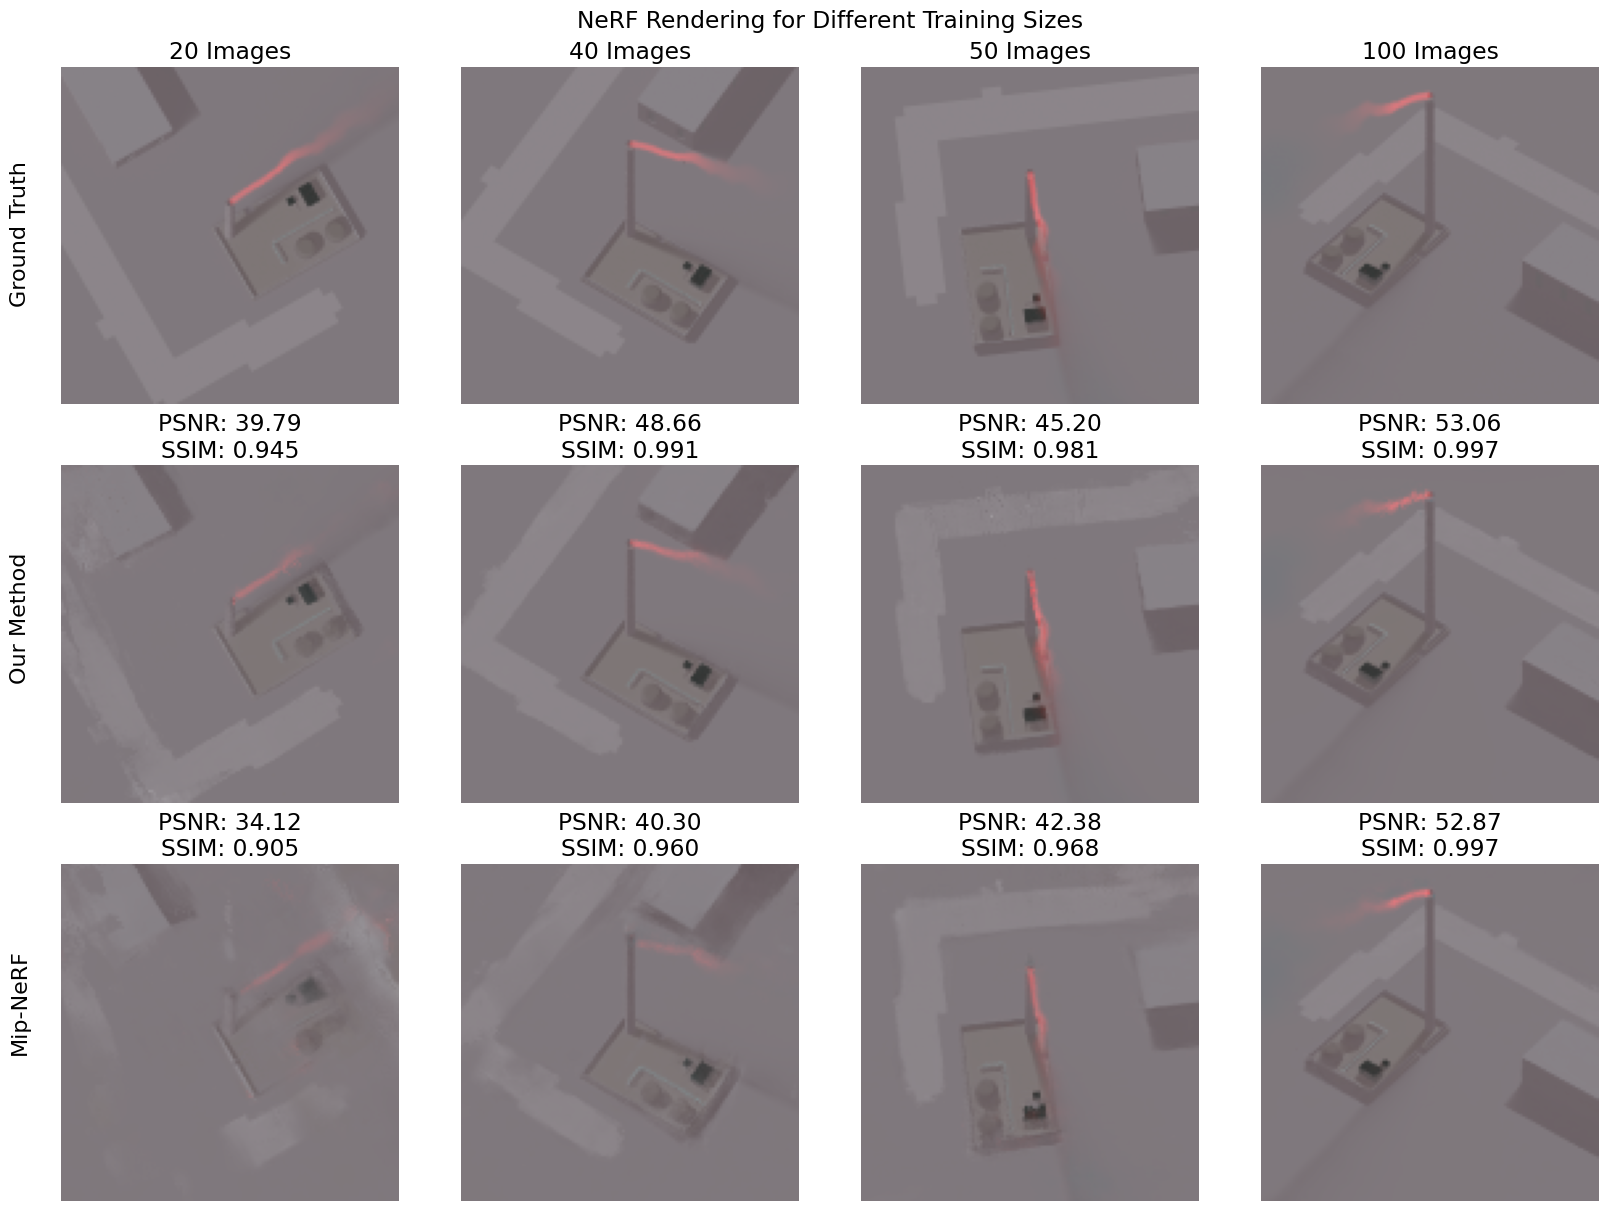

In [ ]:
fig, axs = plt.subplots(3, 4, constrained_layout=True)
fig.set_size_inches(16, 12)

img_idxs = [6, 22, 10, 72]

for i in range(4):
    axs[0, i].imshow(make_img_plottable(all_imgs[img_idxs[i]], scale=1e-6))
    axs[0, i].set_axis_off()



base_folder = "../outputs/complex_facility/hsi_mipnerf_MD_GR"
img_base = "eval_img"
# seeds = [0, 0, 3, 1]  # best img PSNR
# seeds = [0, 0, 1, 0]  # best TPR
# seeds = [0, 0, 4, 1]  # best AUC
seeds = [0, 0, 4, 3]  # best geometric mean
sizes = [20, 40, 50, 100]
for i in range(4):
    img = tifffile.imread(os.path.join(base_folder, f"{sizes[i]}_{seeds[i]}", "hsi-eval", "latest", f"{img_base}_t{img_idxs[i]:04d}.tif"))
    axs[1, i].imshow(make_img_plottable(img, scale=1e-6))
    axs[1, i].set_axis_off()
    filepath = os.path.join(base_folder, f"{sizes[i]}_{seeds[i]}", "hsi-eval", "latest", "per_image_eval_metrics.json")
    with open(filepath, "r") as f:
        metrics = json.load(f)
    img_metrics = metrics[str(img_idxs[i])]
    psnr = img_metrics.get("psnr")
    ssim = img_metrics.get("ssim")
    axs[1, i].set_title(f"PSNR: {psnr:.2f}\nSSIM: {ssim:.3f}")




base_folder = "../outputs/complex_facility/hsi_mipnerf_L2"
img_base = "eval_img"

# seeds = [1, 0, 3, 3]  # best img PSNR
# seeds = [1, 0, 4, 0]  # best TPR
# seeds = [2, 2, 2, 0]  # best AUC
seeds = [3, 4, 4, 0] # best geometric mean
for i in range(4):
    img = tifffile.imread(os.path.join(base_folder, f"{sizes[i]}_{seeds[i]}", "hsi-eval", "latest", f"{img_base}_t{img_idxs[i]:04d}.tif"))
    axs[2, i].imshow(make_img_plottable(img, scale=1e-6))
    axs[2, i].set_axis_off()
    filepath = os.path.join(base_folder, f"{sizes[i]}_{seeds[i]}", "hsi-eval", "latest", "per_image_eval_metrics.json")
    with open(filepath, "r") as f:
        metrics = json.load(f)
    img_metrics = metrics[str(img_idxs[i])]
    psnr = img_metrics.get("psnr")
    ssim = img_metrics.get("ssim")
    axs[2, i].set_title(f"PSNR: {psnr:.2f}\nSSIM: {ssim:.3f}")



fig.suptitle("NeRF Rendering for Different Training Sizes")
axs[0, 0].set_title("20 Images")
axs[0, 1].set_title("40 Images")
axs[0, 2].set_title("50 Images")
axs[0, 3].set_title("100 Images")

# Add side titles manually using fig.text
fig.text(0, 0.81, "Ground Truth", va='center', ha='right', fontsize=16, rotation=90)
fig.text(0, 0.49, "Our Method", va='center', ha='right', fontsize=16, rotation=90)
fig.text(0, 0.17, "Mip-NeRF", va='center', ha='right', fontsize=16, rotation=90)

plt.savefig("Recon_Examples_2.jpeg", bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=600)

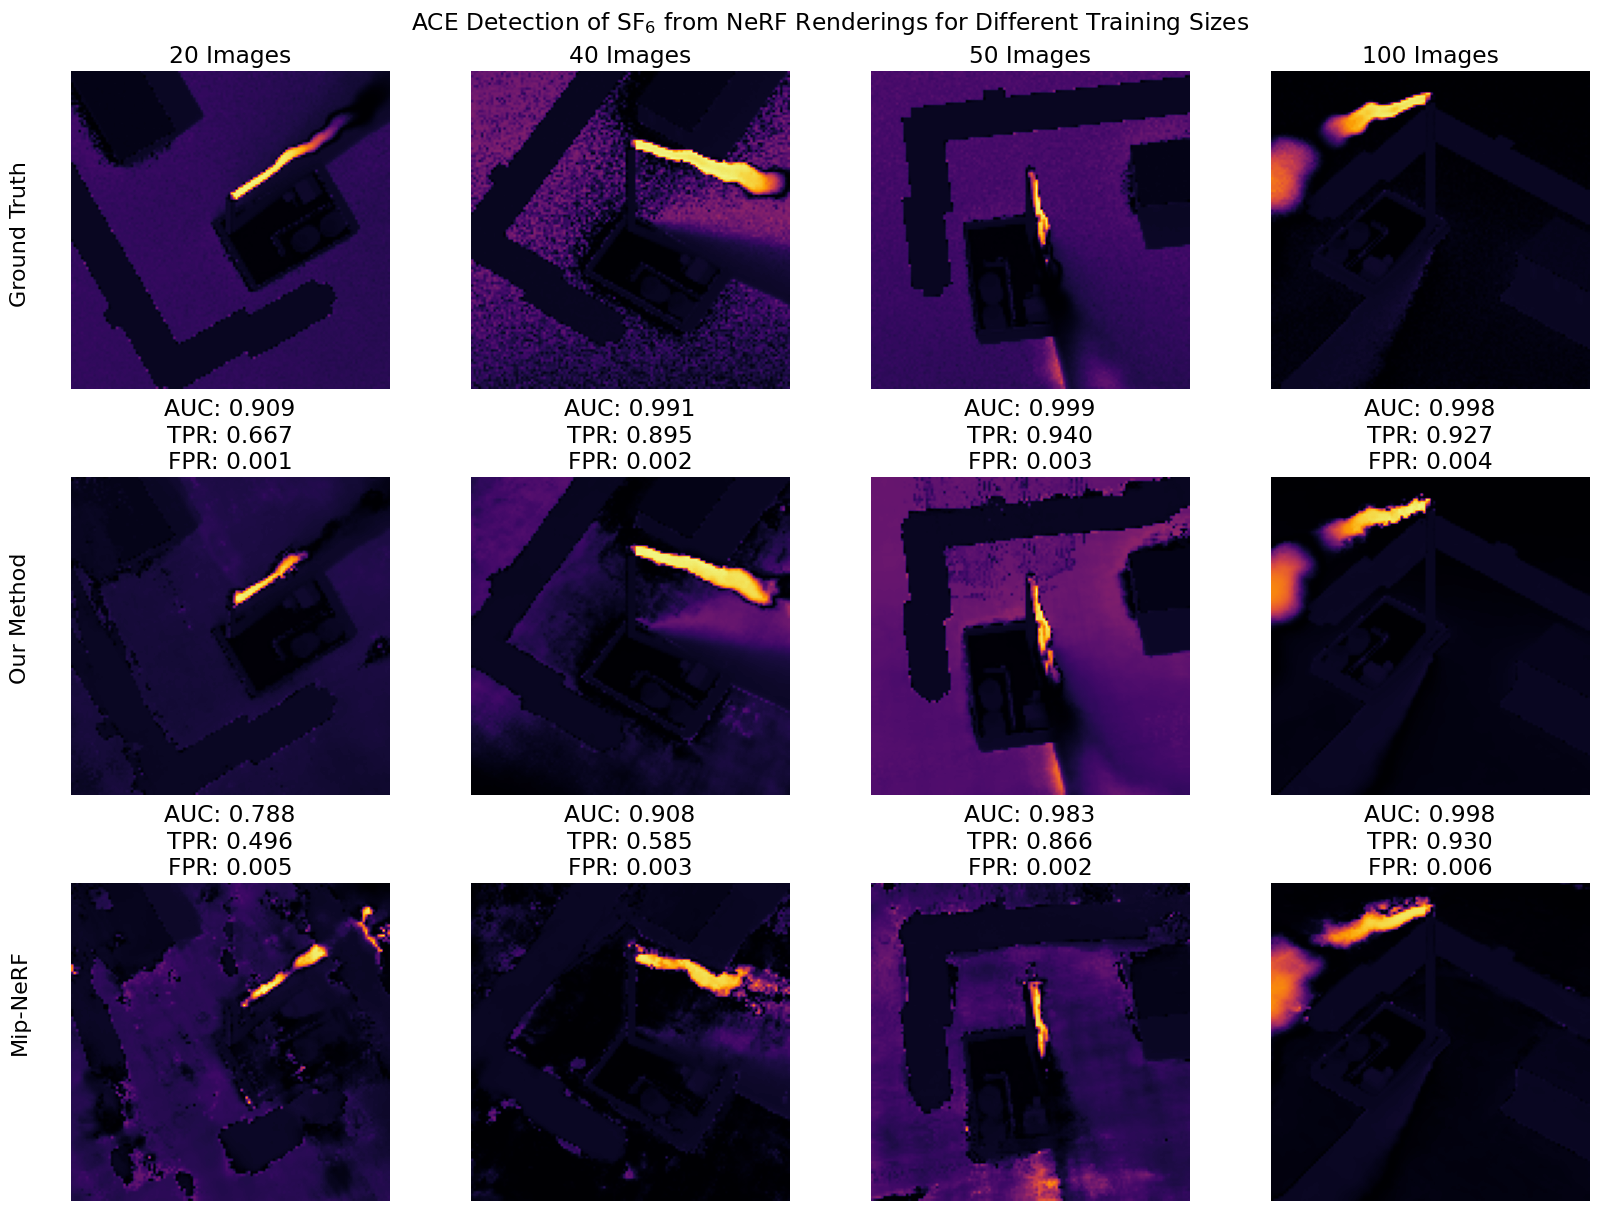

In [ ]:
def ACE_det(img, gt, mean=None, cov=None, regularize_eps=1e-6):
    """
    Compute ACE detection score map.

    Args:
        img: torch.Tensor of shape [H, W, B] — expected in flicks
        gt: numpy array of shape [B,] — target signature (also in flicks)
        mean: optional precomputed background mean (in flicks)
        cov: optional precomputed covariance (in flicks)
        regularize_eps: epsilon for numerical stability
    """
    img_tmp = img.copy()
    H, W, B = img_tmp.shape

    # === Convert to numpy
    pixels = img_tmp.reshape(-1, B).astype(np.float32)

    # === Heuristic: detect if values are in microflicks
    max_val = np.percentile(pixels, 99)
    if max_val > 100:  # threshold for microflicks (very conservative)
        pixels = pixels / 1e6
        if mean is not None:
            mean = mean / 1e6
        if cov is not None:
            cov = cov / (1e6 ** 2)

    # === Center the pixels
    if mean is None:
        mean = pixels.mean(axis=0)
    pixels -= mean

    # === Covariance and inverse
    if cov is None:
        cov = np.cov(pixels.T)
    cov += regularize_eps * np.eye(cov.shape[0])
    C_hat = np.linalg.inv(cov)

    # === ACE computation
    num = gt.T @ C_hat @ pixels.T                     # shape: (N,)
    den1 = gt.T @ C_hat @ gt                          # scalar
    den2 = np.sum((pixels @ C_hat) * pixels, axis=1)  # shape: (N,)
    ace = (num ** 2) / (den1 * den2 + 1e-12)

    return ace.reshape(H, W)



gas_path = "../data/sf6_ext.txt"
data = np.loadtxt(gas_path, delimiter="\t")
wavelengths = 10000 / data[:, 0]
absorption = data[:, 1]
# Interpolate to 128 points
x_new = np.linspace(7.8, 7.8 + 0.044 * 127, 128)
targ_sig = np.interp(x_new, wavelengths, absorption)




fig, axs = plt.subplots(3, 4, constrained_layout=True)
fig.set_size_inches(16, 12)


img_idxs = [6, 22, 10, 72]

for i in range(4):
    # axs[0, i].imshow(make_img_plottable(all_imgs[img_idxs[i]], scale=1e-6))
    axs[0, i].imshow(ACE_det(all_imgs[img_idxs[i]], targ_sig), vmin=0, vmax=1, cmap='inferno')
    axs[0, i].set_axis_off()



base_folder = "../outputs/complex_facility/hsi_mipnerf_MD_GR"
img_base = "eval_ace_img"

# seeds = [0, 0, 1, 0]   # best img TPR
# seeds = [0, 0, 3, 1]  # best img PSNR
# seeds = [0, 0, 4, 1]  # best AUC
seeds = [0, 0, 4, 3]  # best geometric mean
sizes = [20, 40, 50, 100]
for i in range(4):
    img = tifffile.imread(os.path.join(base_folder, f"{sizes[i]}_{seeds[i]}", "hsi-eval", "latest", f"{img_base}_t{img_idxs[i]:04d}.tif"))
    axs[1, i].imshow(img, vmin=0, vmax=1, cmap='inferno')
    axs[1, i].set_axis_off()

    filepath = os.path.join(base_folder, f"{sizes[i]}_{seeds[i]}", "hsi-eval", "latest", "per_image_eval_metrics.json")
    with open(filepath, "r") as f:
        metrics = json.load(f)
    img_metrics = metrics[str(img_idxs[i])]
    auc = img_metrics.get("auc")
    tpr = img_metrics.get("tpr")
    fpr = img_metrics.get("fpr")
    axs[1, i].set_title(f"AUC: {auc:.3f}\nTPR: {tpr:.3f}\nFPR: {fpr:.3f}")




base_folder = "../outputs/complex_facility/hsi_mipnerf_L2"

# seeds = [1, 0, 4, 0]  # best img TPR
# seeds = [1, 4, 3, 3]  # best img PSNR
# seeds = [2, 2, 2, 0]  # best AUC
# seeds = [2, 0, 4, 0] # best geometric mean
seeds = [3, 4, 4, 0] # best geometric mean
for i in range(4):
    img = tifffile.imread(os.path.join(base_folder, f"{sizes[i]}_{seeds[i]}", "hsi-eval", "latest", f"{img_base}_t{img_idxs[i]:04d}.tif"))
    axs[2, i].imshow(img, vmin=0, vmax=1, cmap='inferno')
    axs[2, i].set_axis_off()

    filepath = os.path.join(base_folder, f"{sizes[i]}_{seeds[i]}", "hsi-eval", "latest", "per_image_eval_metrics.json")
    with open(filepath, "r") as f:
        metrics = json.load(f)
    img_metrics = metrics[str(img_idxs[i])]
    auc = img_metrics.get("auc")
    tpr = img_metrics.get("tpr")
    fpr = img_metrics.get("fpr")
    axs[2, i].set_title(f"AUC: {auc:.3f}\nTPR: {tpr:.3f}\nFPR: {fpr:.3f}")


fig.suptitle("ACE Detection of SF$_6$ from NeRF Renderings for Different Training Sizes")
axs[0, 0].set_title("20 Images")
axs[0, 1].set_title("40 Images")
axs[0, 2].set_title("50 Images")
axs[0, 3].set_title("100 Images")


# Add side titles manually using fig.text
fig.text(0, 0.81, "Ground Truth", va='center', ha='right', fontsize=16, rotation=90)
fig.text(0, 0.49, "Our Method", va='center', ha='right', fontsize=16, rotation=90)
fig.text(0, 0.17, "Mip-NeRF", va='center', ha='right', fontsize=16, rotation=90)

plt.savefig("Detection_Examples_2.jpeg", bbox_inches='tight', transparent=True, pad_inches=0.1, dpi=600)

# Fine detail ablation (for MD and GR mainly)

In [ ]:

results = {}
experiments = ["hsi_mipnerf_L2", "hsi_mipnerf", "hsi_mipnerf_MD", "hsi_mipnerf_GR", "hsi_mipnerf_MD_GR", "hsi_mipnerf_MD_GR_L2"]
base_folder = "../outputs/complex_facility"
sizes = [20, 30, 40, 50, 75, 100]
n_seeds = 5


metrics = ["psnr", "ssim", "auc", "tpr"]
all_metrics = ["rmse", "psnr", "ssim", "sam", "prec", "recall", "f1", "auc", "acc", "tnr", "tpr", "fnr", "fpr"]

for experiment in experiments:
    results[experiment] = {}
    for size in sizes:
        results[experiment][size] = {}
        for metric in all_metrics:
            tmp_met = []
            for seed in range(n_seeds):
                try:
                    with open(os.path.join(base_folder, experiment, f"{size}_{seed}", "hsi-eval", "latest", "metrics.json")) as handle:
                        tmp_res = json.load(handle)
                    tmp_met.append(tmp_res["results"][metric])
                except:
                    print("Missing", os.path.join(base_folder, experiment, f"{size}_{seed}", "hsi-eval", "latest", "metrics.json"))
            results[experiment][size][metric] = (np.mean(tmp_met), np.std(tmp_met), tmp_met)

plottable_results = {}
for metric in metrics:
    plottable_results[metric] = {}
    for experiment in experiments:
        plottable_results[metric][experiment] = {}
        ys = []
        yerrs = []
        for size in sizes:
            ys.append(results[experiment][size][metric][0])
            yerrs.append(results[experiment][size][metric][1])
        plottable_results[metric][experiment]["ys"] = ys
        plottable_results[metric][experiment]["yerrs"] = yerrs

plottable_results

{'psnr': {'hsi_mipnerf_L2': {'ys': [33.72107009887695,
    34.597042846679685,
    35.44231491088867,
    36.36302795410156,
    41.99183044433594,
    45.112342834472656],
   'yerrs': [0.4286893828758483,
    0.4643423741168516,
    0.9989291495477237,
    0.5849995018996996,
    0.6816676023037574,
    0.1958385358444849]},
  'hsi_mipnerf': {'ys': [32.66052932739258,
    33.05204391479492,
    35.22105484008789,
    37.671731567382814,
    43.04815139770508,
    45.38741455078125],
   'yerrs': [0.4659904210077497,
    0.8401484360435381,
    0.6131132583900907,
    2.39659620743752,
    1.411912312013398,
    0.1680757438357382]},
  'hsi_mipnerf_MD': {'ys': [32.622704315185544,
    32.90814743041992,
    34.5745735168457,
    36.76759338378906,
    41.25926513671875,
    46.036537170410156],
   'yerrs': [0.495205242102077,
    0.505255351729714,
    0.7752476945643526,
    1.797681581274888,
    2.327665963300037,
    0.5171755756731076]},
  'hsi_mipnerf_GR': {'ys': [36.6128601074218

In [74]:

tmp_exp = ["hsi_mipnerf_L2", "hsi_mipnerf_MD_GR"]
tmp_met = ["psnr", "ssim", "auc", "tpr", "fpr"]
# tmp_met = ["auc"]

print("=== Per-Model Performance Summary (avg ± std | max@seed | min@seed) ===\n")

for experiment in tmp_exp:
    print(f"\n🔍 {experiment}")
    
    for size in sizes:
        print(f"  📏 Image size: {size}")
        
        for metric in tmp_met:
            values = results[experiment][size][metric][2]

            if len(values) == 0:
                print(f"    {metric.upper():<6}  avg = N/A   std = N/A   max = N/A   min = N/A")
            else:
                values = np.array(values)
                mean = np.mean(values)
                std = np.std(values)
                max_val = np.max(values)
                min_val = np.min(values)
                max_seed = np.argmax(values)
                min_seed = np.argmin(values)

                print(f"    {metric.upper():<6}  avg = {mean:.3f}   std = {std:.3f}   max = {max_val:.3f} (seed={max_seed})   min = {min_val:.3f} (seed={min_seed})")
                # print(f"{metric.upper():<6} min, max: {min_val:.3f}, {max_val:.3f}")

=== Per-Model Performance Summary (avg ± std | max@seed | min@seed) ===


🔍 hsi_mipnerf_L2
  📏 Image size: 20
    PSNR    avg = 33.721   std = 0.429   max = 34.566 (seed=1)   min = 33.376 (seed=0)
    SSIM    avg = 0.863   std = 0.006   max = 0.875 (seed=1)   min = 0.858 (seed=0)
    AUC     avg = 0.588   std = 0.048   max = 0.647 (seed=3)   min = 0.527 (seed=2)
    TPR     avg = 0.105   std = 0.033   max = 0.143 (seed=3)   min = 0.064 (seed=2)
    FPR     avg = 0.004   std = 0.002   max = 0.007 (seed=2)   min = 0.002 (seed=3)
  📏 Image size: 30
    PSNR    avg = 34.597   std = 0.464   max = 35.341 (seed=3)   min = 33.887 (seed=2)
    SSIM    avg = 0.873   std = 0.007   max = 0.884 (seed=3)   min = 0.864 (seed=2)
    AUC     avg = 0.638   std = 0.060   max = 0.716 (seed=4)   min = 0.561 (seed=3)
    TPR     avg = 0.185   std = 0.086   max = 0.311 (seed=4)   min = 0.110 (seed=1)
    FPR     avg = 0.006   std = 0.005   max = 0.016 (seed=3)   min = 0.002 (seed=2)
  📏 Image size: 40
    PS

/tmp/ipykernel_3366889/2300882438.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Dark2")


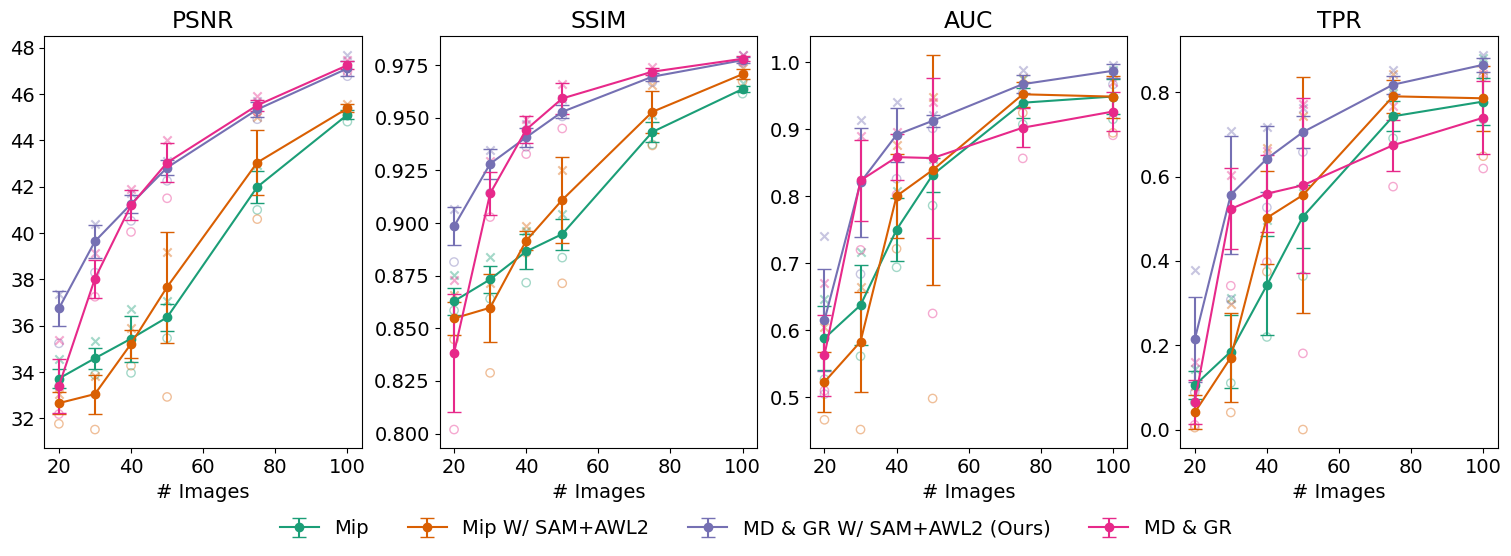

In [ ]:
plottable_results = {}

for metric in metrics:
    plottable_results[metric] = {}
    for experiment in experiments:
        plottable_results[metric][experiment] = {}
        ys, yerrs, max_vals, min_vals = [], [], [], []

        for size in sizes:
            all_vals = np.array(results[experiment][size][metric][2])

            if len(all_vals) == 0:
                ys.append(np.nan)
                yerrs.append(np.nan)
                max_vals.append(np.nan)
                min_vals.append(np.nan)
                continue

            max_val = np.max(all_vals)
            min_val = np.min(all_vals)
            max_vals.append(max_val)
            min_vals.append(min_val)

            # trimmed = all_vals[(all_vals != max_val) & (all_vals != min_val)]

            # if len(trimmed) == 0:
            mean, std = np.mean(all_vals), np.std(all_vals)
            # else:
            #     mean, std = np.mean(trimmed), np.std(trimmed)

            ys.append(mean)
            yerrs.append(std)

        plottable_results[metric][experiment]["ys"] = ys
        plottable_results[metric][experiment]["yerrs"] = yerrs
        plottable_results[metric][experiment]["maxes"] = max_vals
        plottable_results[metric][experiment]["mins"] = min_vals





fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(15, 5)

labels = ["Mip", "Mip W/ SAM+AWL2", "MD", "GR", "MD & GR W/ SAM+AWL2 (Ours)", "MD & GR"]
selected_indices = [0, 1, 4, 5]  # Mip and MD + GR
jitter_scale = 0

# Use full Dark2 palette
cmap = get_cmap("Dark2")
colors = [cmap(i) for i in range(len(labels))]

handles = []
legend_labels = []

for i, metric in enumerate(metrics):
    for k, j in enumerate(selected_indices):
        experiment = experiments[j]
        jitter = np.random.normal(loc=0.0, scale=jitter_scale, size=len(sizes))
        jittered_xs = np.array(sizes) + jitter

        # Trimmed mean and std
        line = axs[i].errorbar(
            x=jittered_xs,
            y=plottable_results[metric][experiment]["ys"],
            yerr=plottable_results[metric][experiment]["yerrs"],
            label=labels[j],
            capsize=5,
            fmt='o-',
            color=colors[k]
        )

        # Plot max value as x
        axs[i].scatter(
            jittered_xs,
            plottable_results[metric][experiment]["maxes"],
            marker='x',
            color=colors[k],
            alpha=0.4,
            label=None
        )

        # Plot min value as hollow o
        axs[i].scatter(
            jittered_xs,
            plottable_results[metric][experiment]["mins"],
            marker='o',
            facecolors='none',
            edgecolors=colors[k],
            alpha=0.4,
            label=None
        )

        axs[i].set_title(metric.upper())
        axs[i].set_xlabel("# Images")

        if i == 0:
            handles.append(line)
            legend_labels.append(labels[j])

# axs[0].legend()
fig.legend(
    handles,
    legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=len(labels),
    frameon=False
)

# # Optional save
plt.savefig("Loss_Ablation.jpeg",
            bbox_inches='tight', transparent=True, pad_inches=0, dpi=600)


/tmp/ipykernel_3366889/3376423354.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set1")


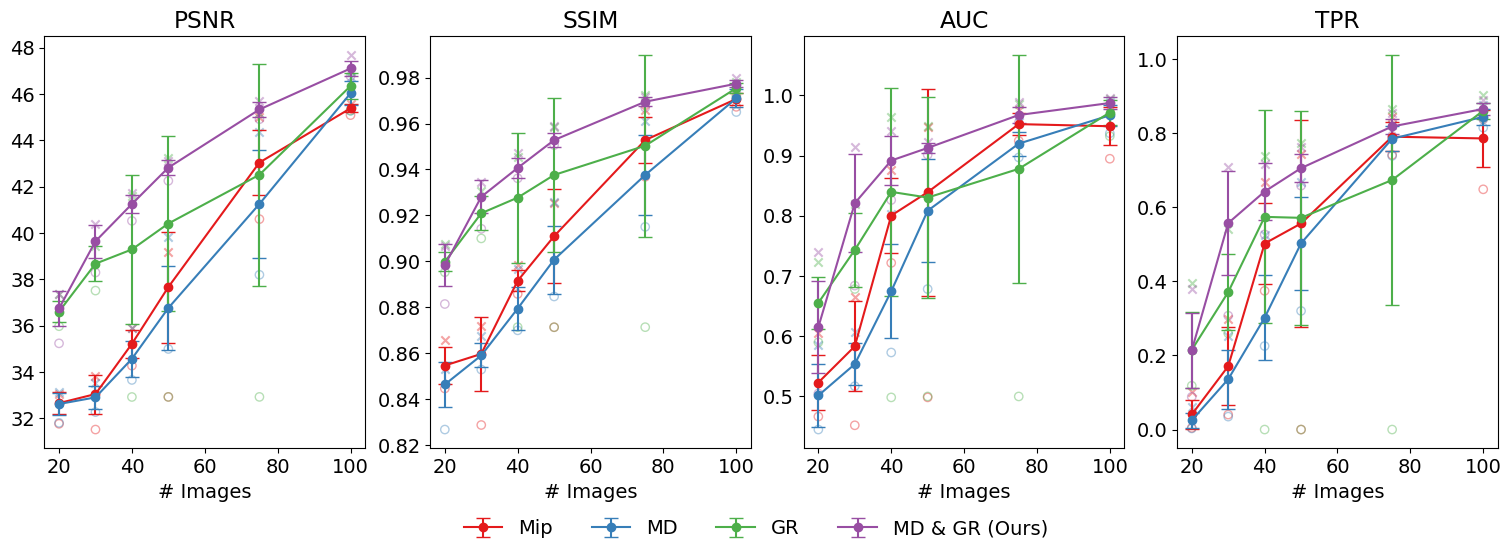

In [ ]:
plottable_results = {}

for metric in metrics:
    plottable_results[metric] = {}
    for experiment in experiments:
        plottable_results[metric][experiment] = {}
        ys, yerrs, max_vals, min_vals = [], [], [], []

        for size in sizes:
            all_vals = np.array(results[experiment][size][metric][2])

            if len(all_vals) == 0:
                ys.append(np.nan)
                yerrs.append(np.nan)
                max_vals.append(np.nan)
                min_vals.append(np.nan)
                continue

            max_val = np.max(all_vals)
            min_val = np.min(all_vals)
            max_vals.append(max_val)
            min_vals.append(min_val)

            # trimmed = all_vals[(all_vals != max_val) & (all_vals != min_val)]

            # if len(trimmed) == 0:
            mean, std = np.mean(all_vals), np.std(all_vals)
            # else:
            #     mean, std = np.mean(trimmed), np.std(trimmed)

            ys.append(mean)
            yerrs.append(std)

        plottable_results[metric][experiment]["ys"] = ys
        plottable_results[metric][experiment]["yerrs"] = yerrs
        plottable_results[metric][experiment]["maxes"] = max_vals
        plottable_results[metric][experiment]["mins"] = min_vals





fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(15, 5)

labels = ["Mip (L2)", "Mip", "MD", "GR", "MD & GR (Ours)", "MD & GR"]
selected_indices = [1, 2, 3, 4]  # Mip and MD + GR
jitter_scale = 0

# Use full Dark2 palette
cmap = get_cmap("Set1")
colors = [cmap(i) for i in range(len(labels))]

handles = []
legend_labels = []

for i, metric in enumerate(metrics):
    for k, j in enumerate(selected_indices):
        experiment = experiments[j]
        jitter = np.random.normal(loc=0.0, scale=jitter_scale, size=len(sizes))
        jittered_xs = np.array(sizes) + jitter

        # Trimmed mean and std
        line = axs[i].errorbar(
            x=jittered_xs,
            y=plottable_results[metric][experiment]["ys"],
            yerr=plottable_results[metric][experiment]["yerrs"],
            label=labels[j],
            capsize=5,
            fmt='o-',
            color=colors[k]
        )

        # Plot max value as x
        axs[i].scatter(
            jittered_xs,
            plottable_results[metric][experiment]["maxes"],
            marker='x',
            color=colors[k],
            alpha=0.4,
            label=None
        )

        # Plot min value as hollow o
        axs[i].scatter(
            jittered_xs,
            plottable_results[metric][experiment]["mins"],
            marker='o',
            facecolors='none',
            edgecolors=colors[k],
            alpha=0.4,
            label=None
        )

        axs[i].set_title(metric.upper())
        axs[i].set_xlabel("# Images")

        if i == 0:
            handles.append(line)
            legend_labels.append(labels[j])

# axs[0].legend()
fig.legend(
    handles,
    legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=len(labels),
    frameon=False
)

# # Optional save
plt.savefig("Model_Ablation.jpeg",
            bbox_inches='tight', transparent=True, pad_inches=0, dpi=600)


/tmp/ipykernel_3366889/3691809538.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Dark2")


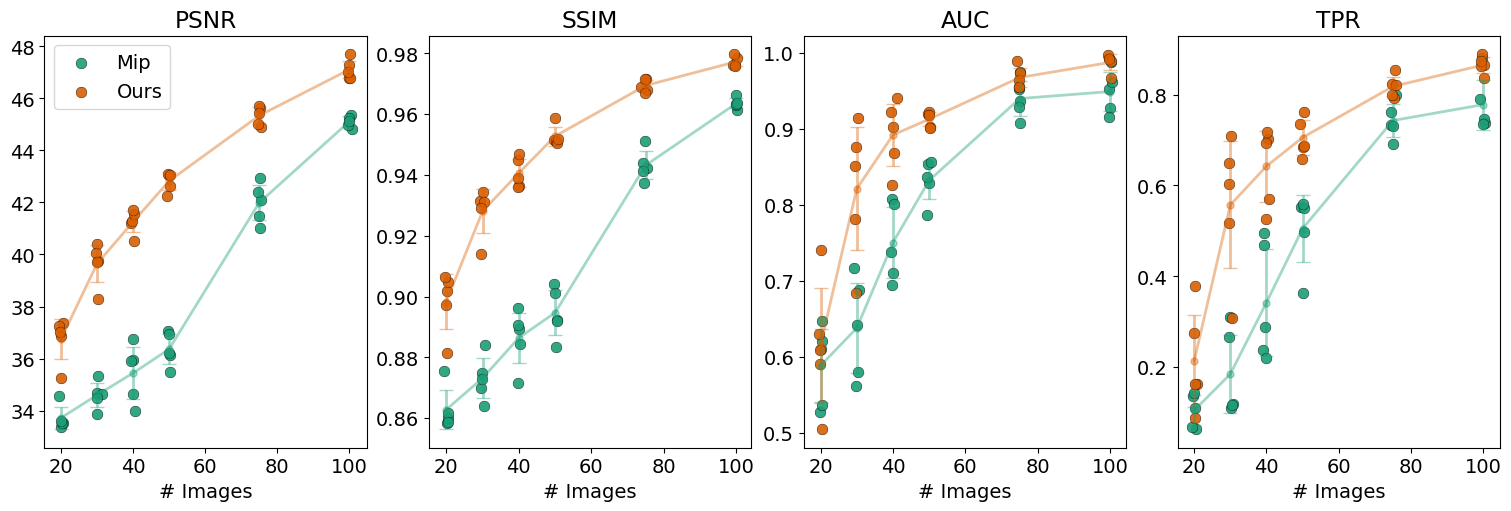

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

fig, axs = plt.subplots(1, 4, constrained_layout=True)
fig.set_size_inches(15, 5)

labels = ["Mip", "Mip+Losses", "MD", "GR", "Ours", "MD+GR+L2"]
selected_indices = [0, 4]  # e.g. Mip and Ours
jitter_scale = 0.4

# Color palette
cmap = get_cmap("Dark2")
colors = [cmap(i) for i in range(len(labels))]

for i, metric in enumerate(metrics):
    for k, j in enumerate(selected_indices):
        experiment = experiments[j]
        color = colors[k]
        base_x = np.array(sizes)

        # Plot all seed results as scatter
        for seed_idx in range(5):
            seed_ys = []
            for size in sizes:
                seed_vals = results[experiment][size][metric][2]
                if len(seed_vals) > seed_idx:
                    seed_ys.append(seed_vals[seed_idx])
                else:
                    seed_ys.append(np.nan)
            jitter = np.random.normal(0, jitter_scale, len(sizes))
            axs[i].scatter(
                base_x + jitter,
                seed_ys,
                color=color,
                alpha=0.9,
                s=60,
                edgecolor='black',
                linewidth=0.3,
                label=labels[j] if seed_idx == 0 else None  # only label once
            )

        # Mean ± std overlay (faint)
        means = []
        stds = []
        for size in sizes:
            vals = np.array(results[experiment][size][metric][2])
            if len(vals) == 0:
                means.append(np.nan)
                stds.append(np.nan)
            else:
                means.append(np.mean(vals))
                stds.append(np.std(vals))

        axs[i].errorbar(
            base_x,
            means,
            yerr=stds,
            fmt='.-',
            color=color,
            alpha=0.4,
            capsize=5,
            linewidth=2,
            markersize=10,
            label=None
        )

        axs[i].set_title(metric.upper())
        axs[i].set_xlabel("# Images")

axs[0].legend()
# Optional save
plt.savefig("Performance_Comparison_scatter.jpeg", bbox_inches='tight', transparent=True, pad_inches=0, dpi=600)
